In [1]:
from datetime import date, timedelta
from scipy.stats import t, jarque_bera, normaltest, kstest
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from src.core.repositories.stock_repository import get_repository, StockRepositoryConfig
from server.config import config as server_config
from src.core.lib.analysis.returns import returns

In [3]:
start = date.today() - timedelta(weeks=52)
end = date.today()

In [4]:
iex_config = server_config['sandbox']['iexcloud']
mysql_config = server_config['sandbox']['db']

In [5]:
repo = get_repository(iex_config=iex_config, mysql_config=mysql_config)

In [6]:
symbols = ['AAPL', 'GOOG', 'IBM', 'NFLX', 'SBUX']
symbol_dataframes = repo.historical_daily_all(symbols, start, end)

In [7]:
df = None
for sym_dataframe in zip(symbols, symbol_dataframes):
    sym, dataframe = sym_dataframe
    closes = pd.DataFrame(data=dataframe[['date','close']])
    closes.set_index('date', inplace=True)
    closes = closes.rename(columns={'close': sym})
    if df is None:
        df = closes
    else:
        df[sym] = closes

In [8]:
df

,AAPL,GOOG,IBM,NFLX,SBUX
date,,,,,
2020-09-21,115.15,1497.24,120.61,489.81,87.07
2020-09-22,117.17,1523.02,121.31,515.70,87.22
2020-09-23,111.36,1426.36,120.38,481.18,85.95
2020-09-24,112.10,1436.92,121.37,494.39,85.05
2020-09-25,114.05,1502.93,123.65,500.98,85.00
...,...,...,...,...,...
2021-09-14,151.38,2926.68,137.61,587.17,123.02
2021-09-15,154.16,2953.12,142.20,587.81,117.08
2021-09-16,151.34,2971.51,140.25,613.60,117.29


In [9]:
df.dropna(axis=0, how='all', inplace=True)

In [10]:
for symbol in symbols:
    df[symbol + '_prev'] = df[symbol].shift(1)
    df[symbol + '_ret'] = df[symbol] / df[symbol + '_prev'] - 1

In [11]:
df

,AAPL,GOOG,IBM,NFLX,SBUX,AAPL_prev,AAPL_ret,GOOG_prev,GOOG_ret,IBM_prev,IBM_ret,NFLX_prev,NFLX_ret,SBUX_prev,SBUX_ret
date,,,,,,,,,,,,,,,
2020-09-21,115.15,1497.24,120.61,489.81,87.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-22,117.17,1523.02,121.31,515.70,87.22,115.15,0.017542,1497.24,0.017218,120.61,0.005804,489.81,0.052857,87.07,0.001723
2020-09-23,111.36,1426.36,120.38,481.18,85.95,117.17,-0.049586,1523.02,-0.063466,121.31,-0.007666,515.70,-0.066938,87.22,-0.014561
2020-09-24,112.10,1436.92,121.37,494.39,85.05,111.36,0.006645,1426.36,0.007403,120.38,0.008224,481.18,0.027453,85.95,-0.010471
2020-09-25,114.05,1502.93,123.65,500.98,85.00,112.10,0.017395,1436.92,0.045939,121.37,0.018786,494.39,0.013330,85.05,-0.000588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-14,151.38,2926.68,137.61,587.17,123.02,153.74,-0.015351,2947.80,-0.007165,142.48,-0.034180,610.02,-0.037458,124.17,-0.009261
2021-09-15,154.16,2953.12,142.20,587.81,117.08,151.38,0.018364,2926.68,0.009034,137.61,0.033355,587.17,0.001090,123.02,-0.048285
2021-09-16,151.34,2971.51,140.25,613.60,117.29,154.16,-0.018293,2953.12,0.006227,142.20,-0.013713,587.81,0.043875,117.08,0.001794


In [12]:
rets = df[[s + '_ret' for s in symbols]].copy()

In [13]:
rets

,AAPL_ret,GOOG_ret,IBM_ret,NFLX_ret,SBUX_ret
date,,,,,
2020-09-21,NaN,NaN,NaN,NaN,NaN
2020-09-22,0.017542,0.017218,0.005804,0.052857,0.001723
2020-09-23,-0.049586,-0.063466,-0.007666,-0.066938,-0.014561
2020-09-24,0.006645,0.007403,0.008224,0.027453,-0.010471
2020-09-25,0.017395,0.045939,0.018786,0.013330,-0.000588
...,...,...,...,...,...
2021-09-14,-0.015351,-0.007165,-0.034180,-0.037458,-0.009261
2021-09-15,0.018364,0.009034,0.033355,0.001090,-0.048285
2021-09-16,-0.018293,0.006227,-0.013713,0.043875,0.001794


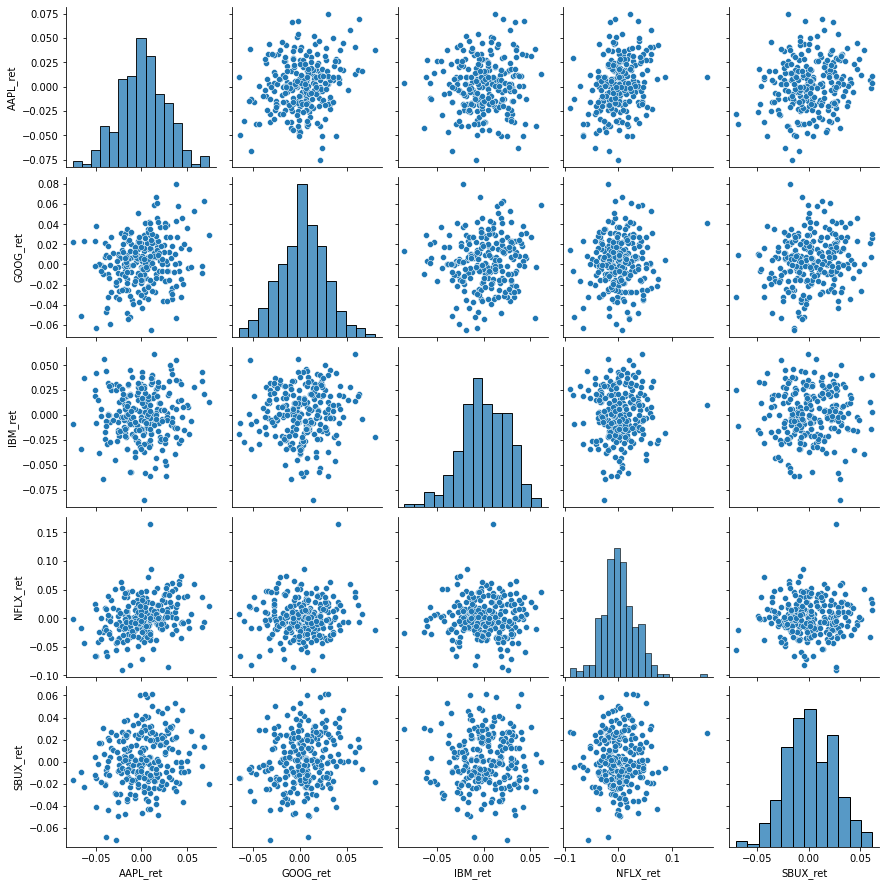

In [14]:
import seaborn as sns
sns.pairplot(rets)

In [15]:
rets.mean()

AAPL_ret    0.001311
GOOG_ret    0.002790
IBM_ret     0.000777
NFLX_ret    0.001326
SBUX_ret    0.001481
dtype: float64

In [16]:
rets.std()

AAPL_ret    0.026220
GOOG_ret    0.024883
IBM_ret     0.025199
NFLX_ret    0.031816
SBUX_ret    0.023902
dtype: float64

Text(0, 0.5, 'Return')

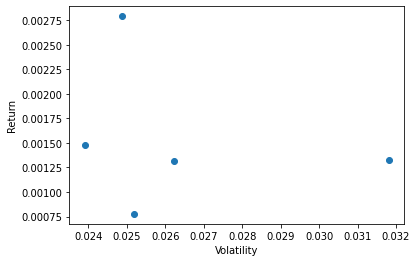

In [17]:
plt.scatter(rets.std(), rets.mean())
plt.xlabel('Volatility')
plt.ylabel('Return')

In [18]:
rets.corr()

,AAPL_ret,GOOG_ret,IBM_ret,NFLX_ret,SBUX_ret
AAPL_ret,1.000000,0.208533,0.052391,0.294662,0.160935
GOOG_ret,0.208533,1.000000,0.072375,0.103666,0.170021
IBM_ret,0.052391,0.072375,1.000000,0.000611,0.025847
NFLX_ret,0.294662,0.103666,0.000611,1.000000,0.014416
SBUX_ret,0.160935,0.170021,0.025847,0.014416,1.000000


In [19]:
rets.cov()

,AAPL_ret,GOOG_ret,IBM_ret,NFLX_ret,SBUX_ret
AAPL_ret,0.000687,0.000136,3.461556e-05,2.458071e-04,0.000101
GOOG_ret,0.000136,0.000619,4.538176e-05,8.206975e-05,0.000100
IBM_ret,0.000035,0.000045,6.350007e-04,4.900304e-07,0.000016
NFLX_ret,0.000246,0.000082,4.900304e-07,1.012244e-03,0.000011
SBUX_ret,0.000101,0.000100,1.556078e-05,1.098371e-05,0.000571
